In [1]:
import os
import re
import glob
import numpy  as np
import pandas as pd

from os.path import expandvars, join, basename

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib widget

In [2]:
def read_mctrue(filename):
    tracks = wcr.read_table(filename, "/wcsimT/Tracks")

    selcols = ("Start_x0", "Start_x1", "Start_x2", "Time", "Dir_x0", "Dir_x1", "Dir_x2", "P", "StopVol")
    
    # read parent particles
    df = tracks.loc[(tracks.Parenttype == 0) & (tracks.Flag == 0) & (tracks.Id == 1), selcols]

    # compute direction angles
    columns = ("x", "y", "z", "t", "theta", "phi", "p", "StopVol")
    x = df["Dir_x0"].values
    y = df["Dir_x1"].values
    z = df["Dir_x2"].values
    theta = np.arccos(z)
    phi   = np.arctan2(y, x)
    phi[(np.sign(phi)<0)] += 2.*np.pi

    df1 = pd.DataFrame(dict(zip( columns
                               , [*df.loc[:, selcols[:4]].values.T
                               , theta, phi
                               , df.loc[:, "P"].values, df.loc[:, "StopVol"].values])))
    return df1

In [5]:
indir = expandvars("$HOME/Software/WCSimFQTuningTools/fiTQun/local/")

filenames = glob.glob(join(indir, "*"))

fitqun  = dict()
for filename in filenames:
    momentum = float(re.findall(r'\d+(?:\.\d+)?', basename(filename))[0])
    fitqun[momentum] = pd.read_csv(filename)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf5 in position 6: invalid start byte

### PID

In [5]:
pids = [(r"$\mu^-$", 2), (r"$\pi^+$", 3), (r"$e^-$", 1)]

for momentum in sorted(fitqun.keys()):
    fits = fitqun[momentum]
    nll = fits.set_index("pid").nll1R

    plt.figure(figsize=[9, 2])

    # -logL bare plot
    plt.subplot(121)
    bins = np.linspace(nll.median()*0.5, nll.median()*1.5, 100)
    for particle, pid in pids:
        h, _ = np.histogram(nll.loc[pid], bins=bins)
        plt.stairs(h, bins, label=particle)
    plt.xlabel(r"$-\log L$")
    plt.legend()

    # quotient plot
    plt.subplot(122)
    bins = np.linspace(-1e3, 1.5e3, 200)
    for particle, pid in pids[:-1]:
        h, bins = np.histogram(-(nll.loc[1].values - nll.loc[pid].values), bins=bins)
        plt.stairs(h, bins, label=particle)
    plt.axvline(0, color="r")
    plt.xlabel(r"$\log ( L_{e^-}/L_{\mu^-,\pi^+})$")
    plt.legend()

    plt.tight_layout()

In [57]:
# # select only events with all reconstructed particles are PC
# sel = fits.groupby("Event").pc.sum() == 0

# print("Momentum:")
# print("---------")
# print("FC efficiency ", sel.sum()/len(sel))
# print()

# fits = fits.set_index("Event").loc[sel]
# nll = fits.set_index("pid").nll1R

In [58]:
# # select only events with all reconstructed particles are PC
# sel = fits.groupby("Event").pc.sum() == 0

# print("Momentum:")
# print("---------")
# print("FC efficiency ", sel.sum()/len(sel))
# print()

# fits = fits.set_index("Event").loc[sel]
# nll = fits.set_index("pid").nll1R

### Reconstruction

In [76]:
pid = 1

for momentum in sorted(fitqun.keys()):
    fits = fitqun[momentum]

    print("FC efficiency ", (fits[fits.pid == pid].pc == 0).sum()/len(fits[fits.pid == pid]))

    plt.figure(figsize=[9, 2])
    plt.subplot(121)

    p = fits[(fits.pid == pid)&(fits.pc == 0)].p.values
    p = fits[(fits.pid == pid)].p.values
    plt.hist(p, bins=np.linspace(momentum*0.5, momentum*2., 100), histtype="step", color="k")
    plt.axvline(momentum, color="r")
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
    plt.gca().tick_params(which='both', direction="in", length=5)
    plt.xlabel("p (MeV/c)")

    plt.subplot(122)
    pull = (fits[(fits.pid == pid)&(fits.pc == 0)].p.values - momentum)/momentum
    pull = (fits[(fits.pid == pid)].p.values - momentum)/momentum
    plt.hist(pull, bins=np.linspace(-1, 1, 100), histtype="step", color="k")
    plt.axvline(0, color="r")
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
    plt.gca().tick_params(which='both', direction="in", length=5)
    plt.xlabel(r"$(p - p_{true})/p_{true}$")

    plt.tight_layout()

FC efficiency  0.8655
FC efficiency  0.19488051194880512
FC efficiency  0.04969006198760248


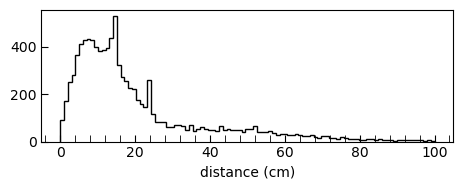

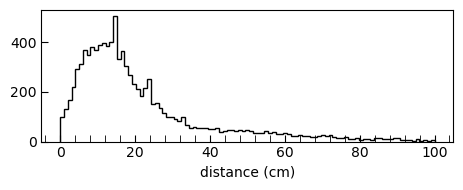

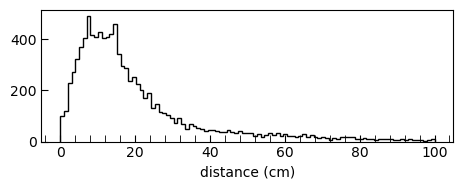

In [50]:
pid = 1

for momentum in sorted(fitqun.keys()):
    fits = fitqun[momentum]

    print("FC efficiency ", (fits[fits.pid == pid].pc == 0).sum()/len(fits[fits.pid == pid]))

    plt.figure(figsize=[9, 2])
    plt.subplot(121)

    df = fits[(fits.pid == pid)&(fits.pc == 0)]
    df = fits[(fits.pid == pid)]
    d = (df.x**2 + df.z**2)**0.5
    plt.hist(d, bins=np.linspace(0, 100, 100), histtype="step", color="k")
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
    plt.gca().tick_params(which='both', direction="in", length=5)
    plt.xlabel("distance (cm)")

    plt.tight_layout()